In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import PatchTSTConfig, PatchTSTModel, PatchTSTForPrediction

In [2]:
df = yf.download("BABA", start="2015-01-01", end="2023-12-31", interval="1d")
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Ticker,BABA,BABA,BABA,BABA,BABA
Date,,,,,
2015-01-02,98.996209,99.452066,97.362732,98.388405,12303400
2015-01-05,97.590655,97.837570,94.874526,95.919189,18337000
2015-01-06,96.156614,98.625819,95.073962,98.122482,15720400
2015-01-07,99.328597,99.471052,96.897380,96.992348,11052200
2015-01-08,97.771108,100.040878,97.514693,99.746475,12942100


# custom config

In [3]:
# =====================================================
# 3. Normalize Features
# =====================================================
scaler = StandardScaler()
scaled = scaler.fit_transform(df)

data = pd.DataFrame(scaled, columns=df.columns, index=df.index)
data.head()


Price,Open,High,Low,Close,Volume
Ticker,BABA,BABA,BABA,BABA,BABA
Date,,,,,
2015-01-02,-0.645842,-0.661370,-0.648896,-0.655322,-0.548548
2015-01-05,-0.670603,-0.689564,-0.693293,-0.698875,-0.039498
2015-01-06,-0.695866,-0.675799,-0.689734,-0.660013,-0.260259
2015-01-07,-0.639987,-0.661038,-0.657200,-0.679946,-0.654111
2015-01-08,-0.667424,-0.651088,-0.646185,-0.631369,-0.494662


In [4]:
# =====================================================
# 4. Create Sliding Windows
#    Input: all OHLCV features
#    Target: only Close (index 3)
# =====================================================
def create_windows(data, input_len=96, pred_len=24):
    """
    data: numpy array shape (time, features)
    returns:
        X: (num_samples, input_len, features)
        y: (num_samples, pred_len, 1)  -> Close only
    """
    X, y = [], []
    for i in range(len(data) - input_len - pred_len):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+pred_len, 3:4])  # Close column only
    return np.array(X), np.array(y)

X, y = create_windows(data.values, input_len=96, pred_len=24)
print("X shape:", X.shape, "y shape:", y.shape)


X shape: (2144, 96, 5) y shape: (2144, 24, 1)


In [6]:
# =====================================================
# 5. Train / Test Split
# =====================================================
train_size = int(0.8 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

print("Train samples:", len(X_train), "Test samples:", len(X_test))

Train samples: 1715 Test samples: 429


In [7]:
# =====================================================
# 6. Torch Dataset
# =====================================================
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return {"past_values": self.X[idx], "future_values": self.y[idx]}

train_ds = StockDataset(X_train, y_train)
test_ds = StockDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

In [19]:
# =====================================================
# 7. PatchTST Model Config
# =====================================================
config = PatchTSTConfig(
    input_size=5,        # number of input features (OHLCV = 5)
    target_size=1,                # only predict Close
    patch_len=16,
    stride=8,
    context_length=96,
    prediction_length=24,
    num_input_channels=5
)

model = PatchTSTForPrediction(config)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [20]:
model.config

PatchTSTConfig {
  "activation_function": "gelu",
  "attention_dropout": 0.0,
  "bias": true,
  "channel_attention": false,
  "channel_consistent_masking": false,
  "context_length": 96,
  "d_model": 128,
  "distribution_output": "student_t",
  "do_mask_input": null,
  "ff_dropout": 0.0,
  "ffn_dim": 512,
  "head_dropout": 0.0,
  "init_std": 0.02,
  "input_size": 5,
  "loss": "mse",
  "mask_type": "random",
  "mask_value": 0,
  "model_type": "patchtst",
  "norm_eps": 1e-05,
  "norm_type": "batchnorm",
  "num_attention_heads": 4,
  "num_forecast_mask_patches": [
    2
  ],
  "num_hidden_layers": 3,
  "num_input_channels": 5,
  "num_parallel_samples": 100,
  "num_targets": 1,
  "output_range": null,
  "patch_len": 16,
  "patch_length": 1,
  "patch_stride": 1,
  "path_dropout": 0.0,
  "pooling_type": "mean",
  "positional_dropout": 0.0,
  "positional_encoding_type": "sincos",
  "pre_norm": true,
  "prediction_length": 24,
  "random_mask_ratio": 0.5,
  "scaling": "std",
  "share_embedding"

In [25]:
# =====================================================
# 8. Training Loop
# =====================================================
for epoch in range(50):  # increase epochs in practice
    model.train()
    total_loss = 0
    for batch in train_loader:
        past = batch["past_values"].to(device)   # shape (B, 96, 5)
        # print(past.shape)
        future = batch["future_values"].to(device) # shape (B, 24, 1)
        # print(future.shape)

        outputs = model(past_values=past, future_values=future)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


c:\Users\Pam\miniconda3\envs\ml\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([32, 24, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Pam\miniconda3\envs\ml\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([19, 24, 1])) that is different to the input size (torch.Size([19, 24, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 0.0840
Epoch 2, Loss: 0.0934
Epoch 3, Loss: 0.0829
Epoch 4, Loss: 0.0749
Epoch 5, Loss: 0.0709
Epoch 6, Loss: 0.0744
Epoch 7, Loss: 0.0674
Epoch 8, Loss: 0.0633
Epoch 9, Loss: 0.0700
Epoch 10, Loss: 0.0592
Epoch 11, Loss: 0.0609
Epoch 12, Loss: 0.0564
Epoch 13, Loss: 0.0529
Epoch 14, Loss: 0.0537
Epoch 15, Loss: 0.0528
Epoch 16, Loss: 0.0575
Epoch 17, Loss: 0.0554
Epoch 18, Loss: 0.0523
Epoch 19, Loss: 0.0471
Epoch 20, Loss: 0.0481
Epoch 21, Loss: 0.0455
Epoch 22, Loss: 0.0514
Epoch 23, Loss: 0.0503
Epoch 24, Loss: 0.0456
Epoch 25, Loss: 0.0424
Epoch 26, Loss: 0.0398
Epoch 27, Loss: 0.0444
Epoch 28, Loss: 0.0421
Epoch 29, Loss: 0.0405
Epoch 30, Loss: 0.0385
Epoch 31, Loss: 0.0365
Epoch 32, Loss: 0.0404
Epoch 33, Loss: 0.0394
Epoch 34, Loss: 0.0431
Epoch 35, Loss: 0.0417
Epoch 36, Loss: 0.0352
Epoch 37, Loss: 0.0383
Epoch 38, Loss: 0.0345
Epoch 39, Loss: 0.0363
Epoch 40, Loss: 0.0385
Epoch 41, Loss: 0.0388
Epoch 42, Loss: 0.0323
Epoch 43, Loss: 0.0335
Epoch 44, Loss: 0.03

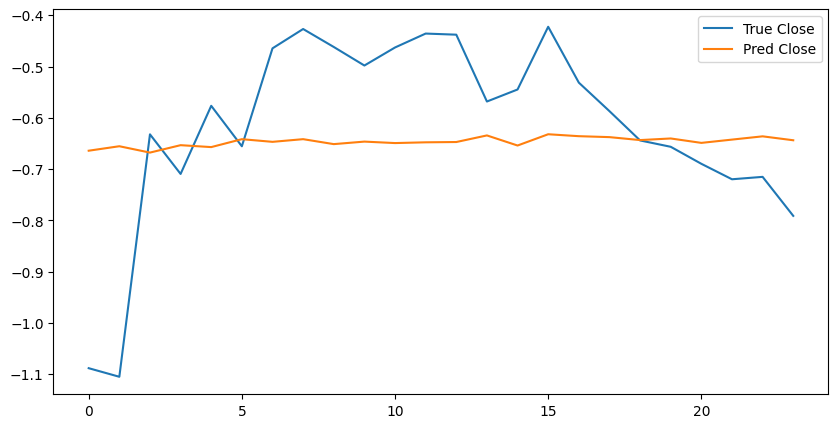

In [26]:
# =====================================================
# 9. Evaluation (Plot Close Forecast)
# =====================================================
model.eval()
with torch.no_grad():
    batch = next(iter(test_loader))
    past = batch["past_values"].to(device)
    future = batch["future_values"].to(device)

    outputs = model(past_values=past)
    preds = outputs.prediction_outputs.cpu().numpy()
    true = future.cpu().numpy()

# Plot prediction vs true Close
plt.figure(figsize=(10,5))
plt.plot(true[0,:,0], label="True Close")
plt.plot(preds[0,:,0], label="Pred Close")
plt.legend()
plt.show()


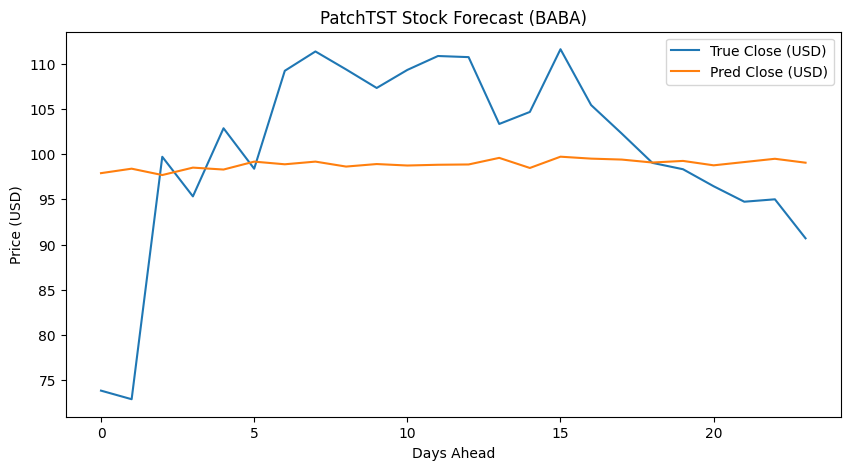

In [28]:
# =====================================================
# 9. Evaluation (Plot Close Forecast in REAL USD)
# =====================================================
model.eval()
with torch.no_grad():
    batch = next(iter(test_loader))
    past = batch["past_values"].to(device)
    future = batch["future_values"].to(device)

    outputs = model(past_values=past)
    preds = outputs.prediction_outputs.cpu().numpy()
    true = future.cpu().numpy()

# -----------------------------------------
# Denormalize (inverse transform Close only)
# -----------------------------------------
# scaler was fitted on all features, we only want column 3 (Close)
close_idx = 3

# Helper: inverse transform close
def inverse_close(arr):
    # arr shape (steps, 1)
    temp = np.zeros((arr.shape[0], len(df.columns)))   # (steps, 5)
    temp[:, close_idx] = arr[:, 0]
    inv = scaler.inverse_transform(temp)
    return inv[:, close_idx]

true_close = inverse_close(true[0])   # ground truth Close (USD)
pred_close = inverse_close(preds[0])  # predicted Close (USD)

# -----------------------------------------
# Plot
# -----------------------------------------
plt.figure(figsize=(10,5))
plt.plot(true_close, label="True Close (USD)")
plt.plot(pred_close, label="Pred Close (USD)")
plt.title("PatchTST Stock Forecast (BABA)")
plt.xlabel("Days Ahead")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


# pretrained model

In [30]:
from huggingface_hub import login

login()  # this will ask for your token

In [ ]:
from transformers import PatchTSTForPrediction, AutoConfig

model_name = "namctin/patchtst_etth1_forecast"

# load pretrained config
config = AutoConfig.from_pretrained(model_name)

# override config for your use case
config.input_size = 5         # your input features (OHLCV)
config.target_size = 1        # predict only Close
config.prediction_length = 24 # how many steps ahead
config.context_length = 96    # same as before
config.num_input_channels = 5 # IMPORTANT for multivariate input

# load pretrained weights with new config
model = PatchTSTForPrediction.from_pretrained(model_name, config=config, ignore_mismatched_sizes=True,)

Some weights of PatchTSTForPrediction were not initialized from the model checkpoint at namctin/patchtst_etth1_forecast and are newly initialized because the shapes did not match:
- model.encoder.positional_encoder.position_enc: found shape torch.Size([43, 128]) in the checkpoint and torch.Size([33, 128]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)  # ⚠️ important

PatchTSTForPrediction(
  (model): PatchTSTModel(
    (scaler): PatchTSTScaler(
      (scaler): PatchTSTStdScaler()
    )
    (patchifier): PatchTSTPatchify()
    (masking): Identity()
    (encoder): PatchTSTEncoder(
      (embedder): PatchTSTEmbedding(
        (input_embedding): Linear(in_features=12, out_features=128, bias=True)
      )
      (positional_encoder): PatchTSTPositionalEncoding(
        (positional_dropout): Identity()
      )
      (layers): ModuleList(
        (0-2): 3 x PatchTSTEncoderLayer(
          (self_attn): PatchTSTAttention(
            (k_proj): Linear(in_features=128, out_features=128, bias=True)
            (v_proj): Linear(in_features=128, out_features=128, bias=True)
            (q_proj): Linear(in_features=128, out_features=128, bias=True)
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
          )
          (dropout_path1): Identity()
          (norm_sublayer1): PatchTSTBatchNorm(
            (batchnorm): BatchNorm1d(128, eps

In [49]:
from torch import nn

outputs = model(past_values=past.to(device), future_values=future.to(device))

loss = outputs.loss
preds = outputs.prediction_outputs  # (batch, 24, 1)

ValueError: Input sequence length (96) doesn't match model configuration (384).

In [42]:
close_idx = 3  # Close column index

# preds: (batch, prediction_length, 1) -> flatten to (batch*pred_len, 1)
preds_flat = preds.detach().cpu().numpy().reshape(-1, 1)

# make placeholder for all features
temp = np.zeros((preds_flat.shape[0], 5))
temp[:, close_idx] = preds_flat[:, 0]

# inverse transform
preds_denorm = scaler.inverse_transform(temp)[:, close_idx]

future_flat = future.detach().cpu().numpy().reshape(-1, 1)
temp_true = np.zeros((future_flat.shape[0], 5))
temp_true[:, close_idx] = future_flat[:, 0]
y_true_denorm = scaler.inverse_transform(temp_true)[:, close_idx]


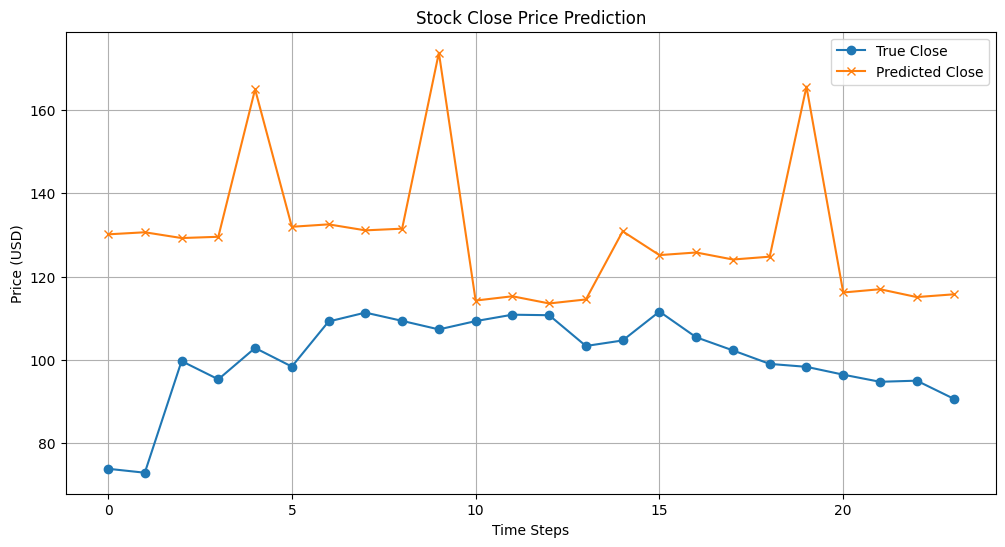

In [43]:
# Example: plot first batch of predictions
plt.figure(figsize=(12,6))

# If you flattened everything, you may want to plot just the first prediction window
# For example, first 24 predicted timesteps
pred_len = 24
plt.plot(y_true_denorm[:pred_len], label="True Close", marker='o')
plt.plot(preds_denorm[:pred_len], label="Predicted Close", marker='x')

plt.title("Stock Close Price Prediction")
plt.xlabel("Time Steps")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


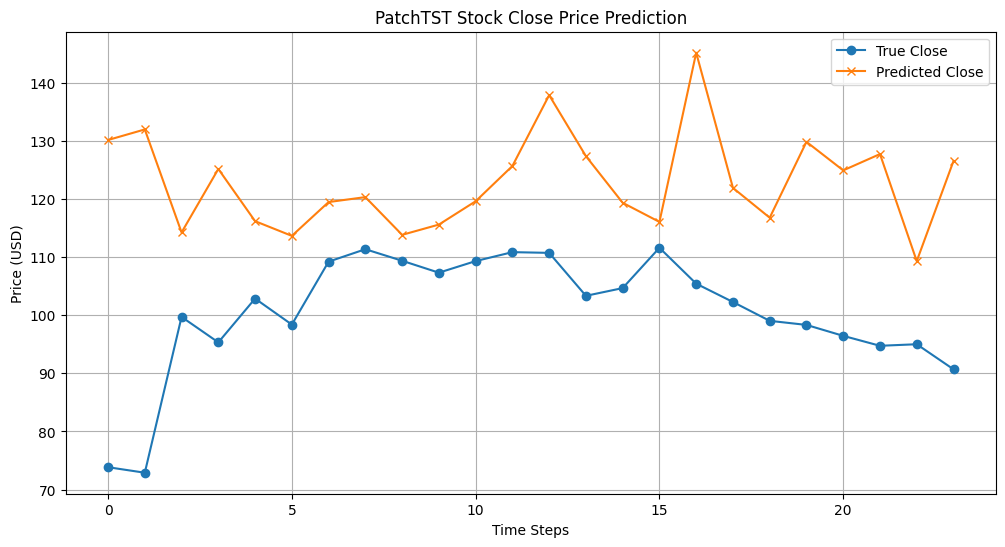

In [45]:
close_idx = 3  # index of Close column

# Get numpy arrays without flattening
preds_np = preds.detach().cpu().numpy()   # shape: (batch, pred_len, 1)
future_np = future.detach().cpu().numpy() # shape: (batch, pred_len, 1)

batch_size, pred_len, _ = preds_np.shape
num_features = scaler.mean_.shape[0]

# Denormalize predictions
preds_denorm = []
for b in range(batch_size):
    temp = np.zeros((pred_len, num_features))
    temp[:, close_idx] = preds_np[b, :, 0]
    preds_denorm.append(scaler.inverse_transform(temp)[:, close_idx])
preds_denorm = np.array(preds_denorm)  # shape: (batch, pred_len)

# Denormalize ground truth
y_true_denorm = []
for b in range(batch_size):
    temp = np.zeros((pred_len, num_features))
    temp[:, close_idx] = future_np[b, :, 0]
    y_true_denorm.append(scaler.inverse_transform(temp)[:, close_idx])
y_true_denorm = np.array(y_true_denorm)

# ----------------------------
# Plot first batch
# ----------------------------
plt.figure(figsize=(12,6))
plt.plot(y_true_denorm[0], label="True Close", marker='o')
plt.plot(preds_denorm[0], label="Predicted Close", marker='x')
plt.title("PatchTST Stock Close Price Prediction")
plt.xlabel("Time Steps")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_true_denorm[0], preds_denorm[0])
mae = mean_absolute_error(y_true_denorm[0], preds_denorm[0])
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 707.0195466091792
Mean Absolute Error: 22.322882950996654
